# MODELO BÁSICO PARA PROBAR CON UN CSV

## IMPORTAR LIBRERÍAS 

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random


## SEMILLA POR REPRODUCIBILIDAD

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## CARGAR UN CSV DE EJEMPLO Y PREPROCESARLO, DIVIDIÉNDOLO EN TRAIN Y TEST

In [3]:
csv_paths = [
    r"C:\Users\Ibon\PycharmProjects\Microgrid\objective2_data_cleaned\Cocoa_aSiMicro03036.csv",
]

dfs = [pd.read_csv(path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"]) for path in csv_paths]
df = pd.concat(dfs, ignore_index=True)

df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y = df['Pmp (W)'].values.astype(np.float32)

scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1) 
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)


## DEFINICIÓN DEL MODELO

In [4]:
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = EnhancedDNN(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EnhancedDNN(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

## SELECCIÓN DE HIPERPARÁMETROS + ENTRENAMIENTO + EVALUACIÓN

C:\Users\Ibon\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Loss: 797.1361
Epoch [2/150], Loss: 50.2613
Epoch [3/150], Loss: 42.5090
Epoch [4/150], Loss: 39.2992
Epoch [5/150], Loss: 36.3063
Epoch [6/150], Loss: 39.2491
Epoch [7/150], Loss: 34.6637
Epoch [8/150], Loss: 32.0268
Epoch [9/150], Loss: 32.5092
Epoch [10/150], Loss: 34.3292
Epoch [11/150], Loss: 30.8804
Epoch [12/150], Loss: 30.1121
Epoch [13/150], Loss: 29.2980
Epoch [14/150], Loss: 30.7464
Epoch [15/150], Loss: 30.8594
Epoch [16/150], Loss: 29.3866
Epoch [17/150], Loss: 32.7604
Epoch [18/150], Loss: 29.3275
Epoch [19/150], Loss: 31.2440
Epoch [20/150], Loss: 23.8932
Epoch [21/150], Loss: 24.9087
Epoch [22/150], Loss: 25.1403
Epoch [23/150], Loss: 27.7557
Epoch [24/150], Loss: 25.4221
Epoch [25/150], Loss: 25.6223
Epoch [26/150], Loss: 30.0973
Epoch [27/150], Loss: 26.3683
Epoch [28/150], Loss: 24.4512
Epoch [29/150], Loss: 25.1009
Epoch [30/150], Loss: 24.7654
⏹️ Early stopping at epoch 30

📊 Test MSE: 3.6056
📏 Test MAE: 1.5181
📈 Test R2: 0.9975


C:\Users\Ibon\AppData\Local\Temp\ipykernel_16116\3587396428.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_onecsv.pth"))


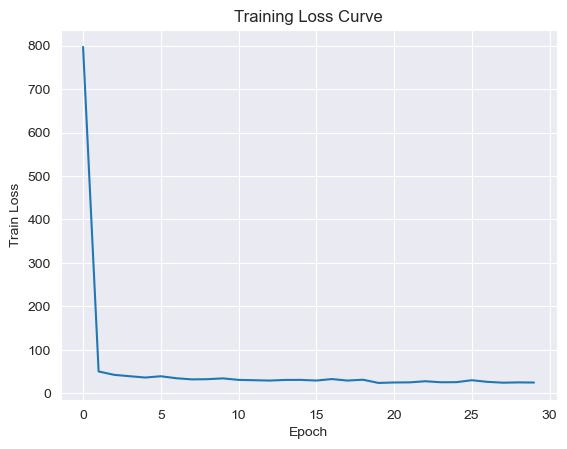

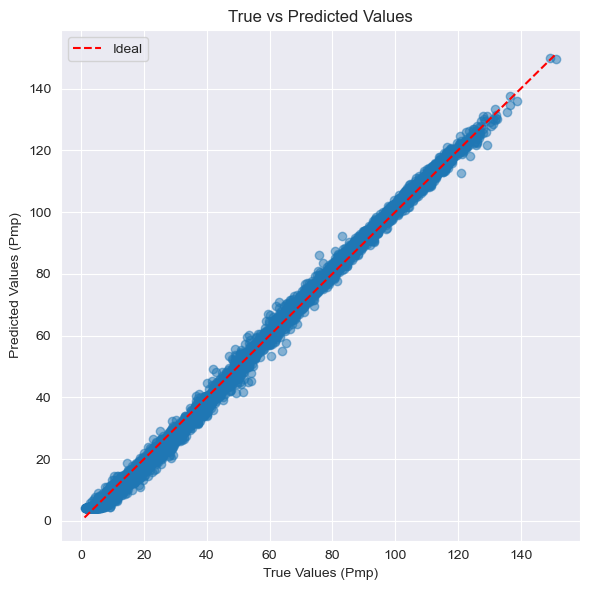

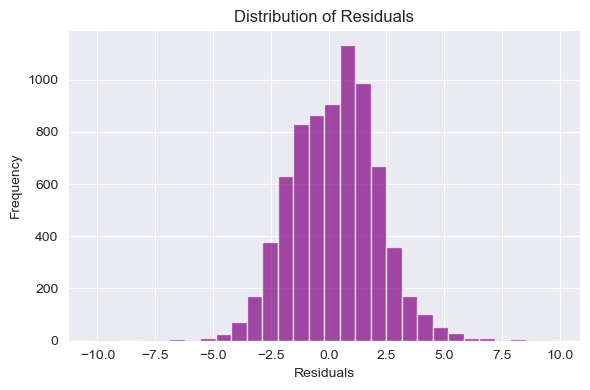

In [5]:
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
criterion = nn.MSELoss()

epochs = 150
best_loss = np.inf
patience = 10
counter = 0
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_onecsv.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load("best_model_onecsv.pth"))

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    residuals = y_test_np - y_pred

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', label='Ideal')
plt.xlabel("True Values (Pmp)")
plt.ylabel("Predicted Values (Pmp)")
plt.title("True vs Predicted Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, alpha=0.7, color='purple')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()